# Example 1: Measuring QNM amplitudes from ringdown waveforms

This notebook demonstrates how to use the $\texttt{fitrd}$ module to extract QNM amplitudes from ringdown waveforms. 

In particular, we calcualte the mode amplitudes presented in Table 1 of Lim and Hughes (2022), for an extreme mass ratio plunge with plunge parameters $\lbrace I,\theta_{\rm fin},{\rm sgn}(\dot{\theta}_{\rm fin}) \rbrace = \lbrace 137^\circ, 79.9^\circ, 1 \rbrace$

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fitrd.fitrd as fitrd

### Calculate fiducial time $t_0$ 

- Load trajectory data $r(t)$
- Calculate fiducial time as radial crossing time of equivalent prograde equatorial light ring, $t_0 = t_{\rm lr-cross}$ [c.f. Eq. (7) in Lim and Hughes (2022)]

In [10]:
traj_data = pd.read_csv("./sample_data/a0.5_thi137_thf079.9_p.traj",delim_whitespace=True,usecols=[0,1], names=['t','r'],skiprows=240000)
lr_radius = 2*(1+np.cos((2./3.)*np.arccos(-np.abs(0.5))))
t_fiducial = np.interp(lr_radius, traj_data['r'].loc[::-1],traj_data['t'].loc[::-1])

### Solve for spheroidal amplitudes over time 

Perform algorithm for a set of spherical modes of index $m$: $\lbrace {h}{_{\ell m}^{\rm N}}(t) \rbrace \rightarrow  \lbrace \mathcal{A}_{kmn},\varphi_{k m n},\mathcal{A}'_{k -m n}, \varphi'_{k -m n} \rbrace$

- Include spheroidal-spherical mode mixing in the range $\ell_{\rm min} \leq \ell \leq |m| + K_{\ell}$ [c.f. Eq. (3.10) in Lim, Khanna, Apte, Hughes (2019)]
- $\texttt{preparesystem}$ pre-computes weights used in the algorithm. If this is the first time running, will store result as a numpy pickle and use for future calculations by default.
- List of extracted QNM modes are labeled by $(\ell, m, I_{\rm mirror})$, where $I_{\rm mirror} = 1$ if mirror mode and $I_{\rm mirror} =0$ if non-mirror mode


In [20]:
k_ell = 4
m_range = np.arange(-4,5)

spherical_modes = {}  # stores labels for spherical modes used by algorithm, for each m
spheroidal_modes = {} # stores labels for spheroidal modes calculated by the algorithm, for each m
spheroidal_coefs = {} # stores spheroidal coefficients at each fitting time, for each m

for m in m_range:
    spherical_modes[m], time, spheroidal_coefs[m] = fitrd.solve_system(m, k_ell, t_fiducial, 
                                                                       [f"./sample_data/h{fitrd.mlabel(m)}_a0.5_thi137_thf079.9_p.dat"],
                                                                       fitrd.preparesystem(m,0.5,k_ell,cachedir='./precomputed_weights'))
    
    spheroidal_modes[m] = fitrd.get_spheroidalmodes(spherical_modes[m])

Note how the mirror modes are extracted from the spherical modes labeled by index $-m$. For example, the $(2,2,1)$ QNM is extracted from the $m = -2$ spherical modes

In [29]:
print('inputted spherical modes  ', spherical_modes[-2])
print('extracted spheroidal modes', spheroidal_modes[-2])

inputted spherical modes   [[2, -2], [3, -2], [4, -2], [5, -2], [6, -2]]
extracted spheroidal modes [[2, -2, 0], [2, 2, 1], [3, -2, 0], [3, 2, 1], [4, -2, 0], [4, 2, 1], [5, -2, 0], [5, 2, 1], [6, -2, 0], [6, 2, 1]]


### Calculate QNM amplitudes
Averaging spheroidal amplitudes over fitting times

In [13]:
# Fit averaging hyperparameters
t_start = t_fiducial + 10
t_end = t_start + 220
t_window = 50

c_amps = {} # store QNM amplitudes for each m
c_phases = {} # store QNM phases for each m

for m in m_range:
    c_amps[m], c_phases[m] = fitrd.postprocess(time,spheroidal_coefs[m],t_start,t_end,t_window)

### Plot algorithm output
Specify which QNM to plot, labeled by $(\ell, m, I_{\rm mirror})$

In [14]:
l = 2
m = 1
I_mirror = 0
mode_to_plot = [l,m,I_mirror]

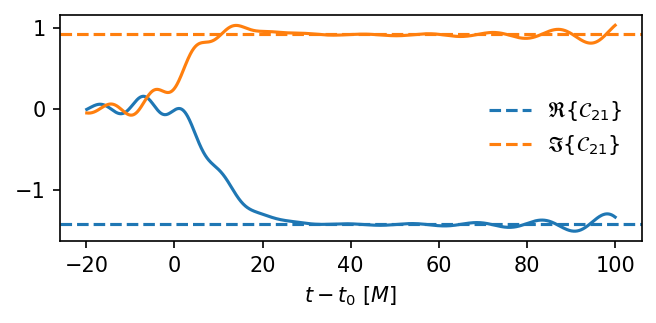

In [15]:
m_spherical = m * (-1)**(I_mirror)

i = spheroidal_modes[m_spherical].index(mode_to_plot)

c_lm_avg = c_amps[m_spherical][i] * np.exp(1j * c_phases[m_spherical][i])

if mode_to_plot[2] == 0:
    mlabel = r"$\mathcal{C}_{%d%d}$" % tuple(mode_to_plot[:2])
elif mode_to_plot[2] == 1:
    mlabel = r"$\mathcal{C}'_{%d%d}$" % tuple(mode_to_plot[:2])
    
mask = (time >= t_fiducial + -20) & (time <= t_fiducial + 100)
c_lm_time = spheroidal_coefs[m_spherical][mask,i]

plt.figure(figsize=(5,2),dpi=150)

plt.plot(time[mask] - t_fiducial,c_lm_time.real,color='C0');
plt.axhline(c_lm_avg.real,ls='--',color='C0',label=r"$\mathfrak{R}${%s}" % mlabel)

plt.plot(time[mask] - t_fiducial,c_lm_time.imag,color='C1');
plt.axhline(c_lm_avg.imag,ls='--',color='C1',label=r"$\mathfrak{I}${%s}" % mlabel)

plt.legend(frameon=False);
plt.xlabel(r'$t - t_0\ \lbrack M \rbrack$');

### Reproduce Table 1 in Lim and Hughes (2022)

In [16]:
modes_in_table = [(2,1),(2,-2),(2,0),(2,-1),(2,2),(3,-3),(3,-1),(3,0)]

table = pd.DataFrame(columns=['Alm','Alm_prime'],index=pd.MultiIndex.from_tuples([mode for mode in modes_in_table],names=['l','m']))
table['Alm'][modes_in_table] = [c_amps[mode[1]][spheroidal_modes[mode[1]].index(list(mode) + [0])] for mode in modes_in_table]
table['Alm_prime'][modes_in_table] = [c_amps[-mode[1]][spheroidal_modes[-mode[1]].index(list(mode) + [1])] for mode in modes_in_table]

In [17]:
pd.set_option("display.precision", 2)
table

Alm Alm_prime
l m                 
2  1  1.69      0.09
  -2  1.18      1.71
   0  1.93      0.49
  -1  1.74      1.04
   2   1.0      0.04
3 -3  0.39      0.61
  -1  0.69      0.23
   0  0.62      0.09